In [20]:
import os
import sys
import json
import shutil
import numpy as np
import pandas as pd

In [21]:
# Helper function
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_json(src_path):
    with open(src_path, 'r') as json_file:
        data = json.load(json_file)
    return data

def write_json(data,dst_path):
    with open(dst_path, 'w') as outfile:
        json.dump(data, outfile)

In [22]:
columns = read_json('../../orderdListGenres.json')
print(len(columns), columns)

20 ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [23]:
# 模型輸出儲存的檔案
SAVE_NAME = 'resnet50_trainable_9e-5_newdata'
HISTORY_SAVE = './history/' + SAVE_NAME + '.csv'
WEIGHTS_SAVE = './weight/' + SAVE_NAME + '.h5'

# ResNet50 Model

In [24]:
# read dataframe
train_df = pd.read_csv('../filename2genreMat.csv')
test_df = pd.read_csv('../poster2genreMat.csv')
print(train_df.shape, test_df.shape)

(30339, 22) (166, 22)


In [25]:
valid_df = train_df.sample(frac = 0.2, random_state = 42)
train_df = train_df.drop(valid_df.index)
print(train_df.shape, valid_df.shape)

(24271, 22) (6068, 22)


In [26]:
from keras.applications import ResNet50
from keras import models
from keras.models import Model
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras import layers
from keras import regularizers, optimizers
# from keras.applications.model import ResNet152

In [27]:
# 資料路徑
DATASET_PATH  = '../IGimg'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 20

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 32

# Epoch 數
NUM_EPOCHS = 100

In [28]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(dataframe=train_df,
                                            directory=DATASET_PATH,
                                            x_col="filename",
                                            y_col=columns,
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="other",
                                            target_size=IMAGE_SIZE)

valid_generator=test_datagen.flow_from_dataframe(dataframe=valid_df,
                                                 directory=DATASET_PATH,
                                                 x_col="filename",
                                                 y_col=columns,
                                                 batch_size=BATCH_SIZE,
                                                 seed=42,
                                                 shuffle=True,
                                                 class_mode="other",
                                                 target_size=IMAGE_SIZE)

Found 24271 validated image filenames.
Found 6068 validated image filenames.


# Fixed the last Layer from 1000 classes into N classes

In [29]:
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [30]:
model = models.Sequential()
model.add(conv_base)        # 將卷積基底視為層加入 Sequential 模型中
model.add(layers.Flatten()) # 攤平
model.add(layers.Dense(256, activation='relu')) 
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid')) # 增加密集層分類器
model.summary() # 查看模型摘要

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_4 (Dense)              (None, 20)                5140      
Total params: 49,283,220
Trainable params: 49,230,100
Non-trainable params: 53,120
_________________________________________________________________


In [31]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = True

print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 216
This is the number of trainable weights after freezing the conv base: 216


In [32]:
model.compile(optimizer=Adam(lr=9e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_4 (Dense)              (None, 20)                5140      
Total params: 49,283,220
Trainable params: 49,230,100
Non-trainable params: 53,120
_________________________________________________________________


# Training Model

In [33]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

In [34]:
# 訓練模型
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = valid_generator,
                              validation_steps = STEP_SIZE_VALID,
                              epochs = NUM_EPOCHS,
                              callbacks=callbacks)

Epoch 1/100
758/758 [==============================] - 226s 298ms/step - loss: 0.2377 - acc: 0.9082 - val_loss: 0.2629 - val_acc: 0.8920
Epoch 2/100
758/758 [==============================] - 218s 287ms/step - loss: 0.1156 - acc: 0.9560 - val_loss: 0.1969 - val_acc: 0.9273
Epoch 3/100
758/758 [==============================] - 217s 286ms/step - loss: 0.0491 - acc: 0.9827 - val_loss: 0.3045 - val_acc: 0.9345


In [35]:
# 儲存訓練好的模型
model.save(WEIGHTS_SAVE)

In [36]:
# save history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

his_df = pd.DataFrame(data = {
    'Epoch' : epochs,
    'Loss' : loss,
    'Acc' : acc,
    'Val_loss' : val_loss,
    'Val_acc' : val_acc
})
his_df = his_df[['Epoch', 'Loss', 'Acc', 'Val_loss', 'Val_acc']]
his_df.to_csv(HISTORY_SAVE, index = False)

# Plot acc & loss

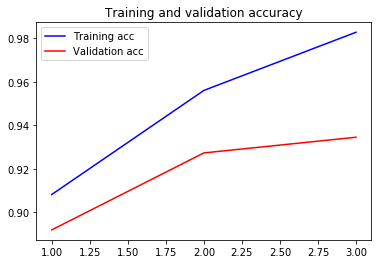

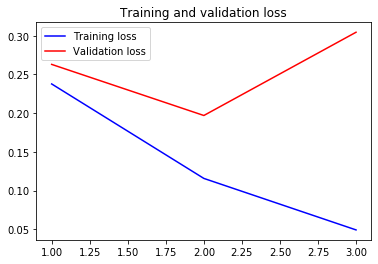

In [37]:
# 繪製結果
import matplotlib.pyplot as plt

plt.figure()

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing

### Testing set: Poster

In [38]:
SAVE_NAME = SAVE_NAME + '_poster'

In [39]:
test_df = pd.read_csv('../poster2genreMat.csv')
test_df

,from,filename,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,../Profiles/21bridgesmovie/poster.jpeg,21bridgesmovie.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,../Profiles/47metersdown/poster.jpeg,47metersdown.jpg,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,../Profiles/abeautifuldaymovie/poster.jpeg,abeautifuldaymovie.jpg,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,../Profiles/abominablemovie/poster.jpeg,abominablemovie.jpg,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../Profiles/adastramovie/poster.jpeg,adastramovie.jpg,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,../Profiles/wrinklestheclown/poster.jpeg,wrinklestheclown.jpg,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
162,../Profiles/xmenmovies/poster.jpeg,xmenmovies.jpg,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
163,../Profiles/yardiefilm/poster.jpeg,yardiefilm.jpg,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
164,../Profiles/yesterdaymovie/poster.jpeg,yesterdaymovie.jpg,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [40]:
DATASET_PATH = '../Poster'

### Testing set: testMatrix.csv

In [41]:
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=DATASET_PATH,
                                                x_col="filename",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=IMAGE_SIZE)

Found 166 validated image filenames.


In [42]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [43]:
test_generator.reset()
pred=model.predict_generator(test_generator,
                                     steps=STEP_SIZE_TEST,
                                     verbose=1)

166/166 [==============================] - 14s 84ms/step


# Output

In [44]:
pred.shape

(166, 20)

In [45]:
predictions = pred

results=pd.DataFrame(predictions, columns=columns)
results["filename"] = test_generator.filenames
ordered_cols = ["filename"] + columns
results = results[ordered_cols] #To get the same column order
results.to_csv("./output/"+ SAVE_NAME + "_result.csv",index=False)

## Label top n dynamic

In [46]:
true_df = test_df

In [47]:
results = pd.read_csv("./output/"+ SAVE_NAME + "_result.csv")
results

,filename,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,21bridgesmovie.jpg,0.978548,0.899821,0.000061,1.183122e-03,0.330618,5.939314e-01,0.000013,0.007816,2.384186e-06,...,1.236796e-04,0.028617,9.322465e-04,0.000451,4.948676e-04,0.003874,0.018726,6.022185e-03,1.573861e-04,1.788139e-06
1,47metersdown.jpg,0.000727,0.035825,0.000306,7.226467e-04,0.000288,4.295558e-03,0.000654,0.990333,5.823374e-05,...,4.729927e-03,0.919602,1.114607e-05,0.690235,3.199875e-04,0.004914,0.000031,5.468935e-01,1.299679e-04,6.157160e-05
2,abeautifuldaymovie.jpg,0.010258,0.006450,0.000868,6.426153e-02,0.001578,3.724784e-03,0.000011,0.273019,4.887581e-06,...,5.362034e-04,0.019211,9.662807e-04,0.000136,8.916695e-01,0.000419,0.004073,8.362532e-05,4.976988e-06,3.516674e-06
3,abominablemovie.jpg,0.000013,0.995406,0.999131,9.536743e-07,0.999365,6.395578e-05,0.000087,0.000177,4.947186e-06,...,8.344650e-07,0.006778,9.871274e-03,0.089865,2.120435e-04,0.000043,0.000065,1.668930e-06,1.788139e-07,4.979968e-04
4,adastramovie.jpg,0.208628,0.579540,0.001195,7.971674e-03,0.008881,1.131531e-01,0.000808,0.618057,5.600452e-04,...,4.984379e-03,0.178822,3.006205e-02,0.285161,1.622099e-02,0.029767,0.000335,8.586407e-03,1.404285e-04,1.443327e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,wrinklestheclown.jpg,0.003402,0.009040,0.000474,6.769836e-03,0.713829,2.407163e-03,0.362606,0.025880,2.099872e-04,...,1.727909e-03,0.973473,1.152965e-02,0.080414,3.867745e-04,0.000035,0.000020,6.399256e-01,6.318092e-06,8.732080e-06
162,xmenmovies.jpg,0.999995,1.000000,0.000001,7.152557e-07,0.000001,2.980232e-08,0.000000,0.000000,2.980232e-07,...,4.172325e-07,0.000001,5.960464e-08,0.000006,5.960464e-08,0.832581,0.000000,6.258488e-07,0.000000e+00,8.940697e-08
163,yardiefilm.jpg,0.064742,0.022118,0.002178,1.233056e-01,0.019370,4.177655e-01,0.000942,0.995851,4.997850e-05,...,1.459122e-01,0.007207,7.745981e-03,0.020711,1.372635e-03,0.107912,0.002493,2.139151e-03,1.043546e-02,2.894938e-03
164,yesterdaymovie.jpg,0.001096,0.002752,0.002169,1.275292e-02,0.558593,1.017848e-02,0.000040,0.652635,2.344251e-04,...,1.557648e-03,0.002323,1.154956e-02,0.008612,3.703642e-01,0.003676,0.000415,5.916774e-03,1.502037e-05,7.599592e-06


In [48]:
labels = read_json('../../genresDic.json')

In [49]:
def countAcc(predList, trueList):
    fraction = 0
    denominator = len(trueList)
    for g in predList:
        if g in trueList:
            fraction += 1 
    return fraction / denominator

In [51]:
li = []
for i, row in true_df.iterrows():
    username = row['filename']
    if username == results.loc[i,:]['filename']: # username equals
        print(i, username)
        accname = username.split('.')[0]
        truth = labels[accname]
        numTrue = sum(row[2:])
        print('count:', numTrue)
        
        s = results.loc[i,:][1:]
        top_n = s.sort_values(ascending=False)[:numTrue]
        inList = list(top_n.index)
        
        onehot = []
        for g in columns:
            onehot.append(int(g in inList))
            
        accu = countAcc(inList, truth)
        print(accu, inList, truth)
        
        appList = [username, accu, truth, inList] + onehot
        li.append(appList)
        

0 21bridgesmovie.jpg
count: 3
0.6666666666666666 ['Action', 'Adventure', 'Crime'] ['Action', 'Crime', 'Drama']
1 47metersdown.jpg
count: 3
0.6666666666666666 ['Drama', 'Horror', 'Mystery'] ['Adventure', 'Drama', 'Horror']
2 abeautifuldaymovie.jpg
count: 2
0.5 ['Romance', 'Drama'] ['Biography', 'Drama']
3 abominablemovie.jpg
count: 3
1.0 ['Comedy', 'Animation', 'Adventure'] ['Adventure', 'Animation', 'Comedy']
4 adastramovie.jpg
count: 3
0.6666666666666666 ['Fantasy', 'Drama', 'Adventure'] ['Adventure', 'Drama', 'Mystery']
5 adogsjourneymovie.jpg
count: 3
0.6666666666666666 ['Drama', 'Romance', 'Adventure'] ['Adventure', 'Comedy', 'Drama']
6 aftermathmovie.jpg
count: 3
0.6666666666666666 ['Drama', 'Romance', 'History'] ['Drama', 'Romance', 'War']
7 aftermovie.jpg
count: 2
0.0 ['Action', 'Adventure'] ['Drama', 'Romance']
8 ahiddenlifefilm.jpg
count: 3
1.0 ['Drama', 'War', 'Biography'] ['Biography', 'Drama', 'War']
9 alitamovie.jpg
count: 3
1.0 ['Adventure', 'Action', 'Sci-Fi'] ['Action',

In [52]:
acc_df = pd.DataFrame(li, columns = ['username', 'acc', 'truth', 'top_n'] + columns)
acc_df

,username,acc,truth,top_n,Action,Adventure,Animation,Biography,Comedy,Crime,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,21bridgesmovie.jpg,0.666667,"[Action, Crime, Drama]","[Action, Adventure, Crime]",1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,47metersdown.jpg,0.666667,"[Adventure, Drama, Horror]","[Drama, Horror, Mystery]",0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,abeautifuldaymovie.jpg,0.500000,"[Biography, Drama]","[Romance, Drama]",0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,abominablemovie.jpg,1.000000,"[Adventure, Animation, Comedy]","[Comedy, Animation, Adventure]",0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,adastramovie.jpg,0.666667,"[Adventure, Drama, Mystery]","[Fantasy, Drama, Adventure]",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,wrinklestheclown.jpg,0.666667,"[Comedy, Documentary, Horror]","[Horror, Comedy, Thriller]",0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0
162,xmenmovies.jpg,1.000000,"[Action, Adventure, Sci-Fi]","[Adventure, Action, Sci-Fi]",1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
163,yardiefilm.jpg,1.000000,"[Crime, Drama]","[Drama, Crime]",0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
164,yesterdaymovie.jpg,0.333333,"[Comedy, Fantasy, Music]","[Drama, Comedy, Romance]",0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [53]:
acc_df.to_csv("./output/"+ SAVE_NAME + "_bi.csv", index = 0)

In [54]:
acc_df['acc'].mean()

0.7309236947791166

# Feature Extraction
## 測試reload model準確度

In [55]:
SAVE_NAME = 'test'
DATASET_PATH = '../Poster'

In [56]:
WEIGHTS_LOAD = './weight/resnet50_trainable_9e-5_newdata.h5'

from keras.models import load_model

model = load_model(WEIGHTS_LOAD)

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dense_4 (Dense)              (None, 20)                5140      
Total params: 49,283,220
Trainable params: 49,230,100
Non-trainable params: 53,120
_________________________________________________________________


In [58]:
test_df = pd.read_csv('../poster2genreMat.csv')
test_df

,from,filename,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,../Profiles/21bridgesmovie/poster.jpeg,21bridgesmovie.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,../Profiles/47metersdown/poster.jpeg,47metersdown.jpg,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,../Profiles/abeautifuldaymovie/poster.jpeg,abeautifuldaymovie.jpg,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,../Profiles/abominablemovie/poster.jpeg,abominablemovie.jpg,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../Profiles/adastramovie/poster.jpeg,adastramovie.jpg,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,../Profiles/wrinklestheclown/poster.jpeg,wrinklestheclown.jpg,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
162,../Profiles/xmenmovies/poster.jpeg,xmenmovies.jpg,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
163,../Profiles/yardiefilm/poster.jpeg,yardiefilm.jpg,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
164,../Profiles/yesterdaymovie/poster.jpeg,yesterdaymovie.jpg,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [59]:
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=DATASET_PATH,
                                                x_col="filename",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=IMAGE_SIZE)

Found 166 validated image filenames.


In [60]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [61]:
test_generator.reset()
pred=model.predict_generator(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)

166/166 [==============================] - 13s 78ms/step


In [62]:
pred.shape

(166, 20)

In [63]:
predictions = pred

results=pd.DataFrame(predictions, columns=columns)
results["filename"] = test_generator.filenames
ordered_cols = ["filename"] + columns
results = results[ordered_cols] #To get the same column order
results.to_csv("./output/"+ SAVE_NAME + "_result.csv",index=False)

In [64]:
true_df = test_df
labels = read_json('../../genresDic.json')

In [65]:
def countAcc(predList, trueList):
    fraction = 0
    denominator = len(trueList)
    for g in predList:
        if g in trueList:
            fraction += 1 
    return fraction / denominator

In [66]:
li = []
for i, row in true_df.iterrows():
    username = row['filename']
    if username == results.loc[i,:]['filename']: # username equals
        print(i, username)
        accname = username.split('.')[0]
        truth = labels[accname]
        numTrue = sum(row[2:])
        print('count:', numTrue)
        
        s = results.loc[i,:][1:]
        top_n = s.sort_values(ascending=False)[:numTrue]
        inList = list(top_n.index)
        
        onehot = []
        for g in columns:
            onehot.append(int(g in inList))
            
        accu = countAcc(inList, truth)
        print(accu, inList, truth)
        
        appList = [username, accu, truth, inList] + onehot
        li.append(appList)
        

0 21bridgesmovie.jpg
count: 3
0.6666666666666666 ['Action', 'Adventure', 'Crime'] ['Action', 'Crime', 'Drama']
1 47metersdown.jpg
count: 3
0.6666666666666666 ['Drama', 'Horror', 'Mystery'] ['Adventure', 'Drama', 'Horror']
2 abeautifuldaymovie.jpg
count: 2
0.5 ['Romance', 'Drama'] ['Biography', 'Drama']
3 abominablemovie.jpg
count: 3
1.0 ['Comedy', 'Animation', 'Adventure'] ['Adventure', 'Animation', 'Comedy']
4 adastramovie.jpg
count: 3
0.6666666666666666 ['Fantasy', 'Drama', 'Adventure'] ['Adventure', 'Drama', 'Mystery']
5 adogsjourneymovie.jpg
count: 3
0.6666666666666666 ['Drama', 'Romance', 'Adventure'] ['Adventure', 'Comedy', 'Drama']
6 aftermathmovie.jpg
count: 3
0.6666666666666666 ['Drama', 'Romance', 'History'] ['Drama', 'Romance', 'War']
7 aftermovie.jpg
count: 2
0.0 ['Action', 'Adventure'] ['Drama', 'Romance']
8 ahiddenlifefilm.jpg
count: 3
1.0 ['Drama', 'War', 'Biography'] ['Biography', 'Drama', 'War']
9 alitamovie.jpg
count: 3
1.0 ['Adventure', 'Action', 'Sci-Fi'] ['Action',

In [67]:
acc_df = pd.DataFrame(li, columns = ['username', 'acc', 'truth', 'top_n'] + columns)
acc_df['acc'].mean()

0.7309236947791166

## 萃取97部電影imdb的feature

### Poster Feature Vector

In [68]:
test_generator

In [78]:
extract_layer = Model(inputs=model.input,
                      outputs=model.get_layer('dense_3').output)
#以这个model的预测值作为输出
extract_output = extract_layer.predict_generator(test_generator,
                                                 steps=STEP_SIZE_TEST,
                                                 verbose=1)
print(extract_output.shape)

166/166 [==============================] - 13s 79ms/step
(166, 256)


In [79]:
idx = test_generator.filenames
print(len(idx), idx)

166 ['21bridgesmovie.jpg', '47metersdown.jpg', 'abeautifuldaymovie.jpg', 'abominablemovie.jpg', 'adastramovie.jpg', 'adogsjourneymovie.jpg', 'aftermathmovie.jpg', 'aftermovie.jpg', 'ahiddenlifefilm.jpg', 'alitamovie.jpg', 'amazinggracemov.jpg', 'angelhasfallen.jpg', 'angrybirdsmovie.jpg', 'annabellemovie.jpg', 'annamovie.jpg', 'apollo11movie.jpg', 'arcticdogsmovie.jpg', 'arcticmovie.jpg', 'artofracingmovie.jpg', 'avengers.jpg', 'beachbummovie.jpg', 'bernadettefilm.jpg', 'blackandbluemovie.jpg', 'blackchristmas.jpg', 'blindedbythelightmovie.jpg', 'bombshellmovie.jpg', 'booksmart.jpg', 'breakthroughmovie.jpg', 'brianbanksmovie.jpg', 'brightburnmovie.jpg', 'brittanyrunsmov.jpg', 'captainmarvelofficial.jpg', 'captivestatemovie.jpg', 'catsmovie.jpg', 'charliesangels.jpg', 'childsplaymovie.jpg', 'clarathefilm.jpg', 'coldpursuitmovie.jpg', 'countdown.jpg', 'currentwarmovie.jpg', 'darkwatersmovie.jpg', 'detectivepikachumovie.jpg', 'disneyaladdin.jpg', 'disneyfrozen.jpg', 'disneymaleficent.jpg'

In [80]:
res=pd.DataFrame(extract_output, index = idx)
res

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
21bridgesmovie.jpg,3.387048,0.0,0.0,4.010987,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.836308
47metersdown.jpg,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,4.681221,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.379242
abeautifuldaymovie.jpg,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.466343
abominablemovie.jpg,6.915580,0.0,0.0,0.000000,0.0,0.0,0.0,9.828920,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.211412
adastramovie.jpg,0.028479,0.0,0.0,1.667131,0.0,0.0,0.0,2.236325,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.415615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wrinklestheclown.jpg,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.045490,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.886146
xmenmovies.jpg,18.459608,0.0,0.0,8.158738,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.567715
yardiefilm.jpg,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.618315,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.543765
yesterdaymovie.jpg,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,4.909546,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.108469


In [81]:
res.to_csv("./output/PosterFeatureVec.csv", header=False)

### IG images

In [82]:
DATASET_PATH  = '../IGimg'
train_df = pd.read_csv('../filename2genreMat.csv')
train_df

,from,filename,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,../Posts/21bridgesmovie/2175018306402404394_86...,21bridgesmovie_17239.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,../Posts/21bridgesmovie/2177917366494984182_86...,21bridgesmovie_17240.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,../Posts/21bridgesmovie/2169038472928885102_86...,21bridgesmovie_17241.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,../Posts/21bridgesmovie/2198935854680323790_86...,21bridgesmovie_17242.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,../Posts/21bridgesmovie/2182191168477234869_86...,21bridgesmovie_17243.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30334,../Posts/zombieland/2137359683396335880_913973...,zombieland_5575.jpg,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
30335,../Posts/zombieland/2137359683396335880_913973...,zombieland_5576.jpg,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
30336,../Posts/zombieland/2137359683396335880_913973...,zombieland_5577.jpg,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
30337,../Posts/zombieland/2218432031066716113_913973...,zombieland_5578.jpg,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [83]:
train_generator=datagen.flow_from_dataframe(dataframe=train_df,
                                            directory=DATASET_PATH,
                                            x_col="filename",
                                            batch_size=1,
                                            seed=42,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=IMAGE_SIZE)

Found 30339 validated image filenames.


In [84]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
print(STEP_SIZE_TRAIN)

30339


In [85]:
extract_layer = Model(inputs=model.input,
                      outputs=model.get_layer('dense_3').output)
#以这个model的预测值作为输出
extract_output = extract_layer.predict_generator(train_generator,
                                                 steps=STEP_SIZE_TRAIN,
                                                 verbose=1)
print(extract_output.shape)

30339/30339 [==============================] - 270s 9ms/step
(30339, 256)


In [86]:
idx = train_generator.filenames
print(len(idx), idx)

30339 ['21bridgesmovie_17239.jpg', '21bridgesmovie_17240.jpg', '21bridgesmovie_17241.jpg', '21bridgesmovie_17242.jpg', '21bridgesmovie_17243.jpg', '21bridgesmovie_17244.jpg', '21bridgesmovie_17245.jpg', '21bridgesmovie_17246.jpg', '21bridgesmovie_17247.jpg', '21bridgesmovie_17248.jpg', '21bridgesmovie_17249.jpg', '21bridgesmovie_17250.jpg', '21bridgesmovie_17251.jpg', '21bridgesmovie_17252.jpg', '21bridgesmovie_17253.jpg', '21bridgesmovie_17254.jpg', '21bridgesmovie_17255.jpg', '21bridgesmovie_17256.jpg', '21bridgesmovie_17257.jpg', '21bridgesmovie_17258.jpg', '21bridgesmovie_17259.jpg', '21bridgesmovie_17260.jpg', '21bridgesmovie_17261.jpg', '21bridgesmovie_17262.jpg', '21bridgesmovie_17263.jpg', '21bridgesmovie_17264.jpg', '21bridgesmovie_17265.jpg', '21bridgesmovie_17266.jpg', '21bridgesmovie_17267.jpg', '21bridgesmovie_17268.jpg', '21bridgesmovie_17269.jpg', '21bridgesmovie_17270.jpg', '21bridgesmovie_17271.jpg', '21bridgesmovie_17272.jpg', '21bridgesmovie_17273.jpg', '21bridgesmov

In [87]:
res=pd.DataFrame(extract_output, index = idx)
res

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
21bridgesmovie_17239.jpg,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.573396
21bridgesmovie_17240.jpg,0.000000,0.0,0.0,6.402987,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.378065
21bridgesmovie_17241.jpg,0.000000,0.0,0.0,1.087315,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.689849
21bridgesmovie_17242.jpg,0.000000,0.0,0.0,1.142214,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.632139
21bridgesmovie_17243.jpg,0.000000,0.0,0.0,1.679773,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.076295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zombieland_5575.jpg,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.305132
zombieland_5576.jpg,8.601309,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.551939
zombieland_5577.jpg,1.387509,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.008000
zombieland_5578.jpg,4.216678,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.249840


In [88]:
res.to_csv("./output/IGimgFeatureVec.csv", header=False)